In [1]:
import numpy as np

# 0 = no wind, 1 = 1 up, 2 = 2 up
windy_gw = np.zeros((7, 10), dtype=np.int8)

windy_gw[0:7, 3:6] = 1
windy_gw[0:7, 8] = 1

windy_gw[0:7, 6:8] = 2

start_location = np.array([3, 0])

goal = np.array([3, 7])

actions = np.array([
    [1, 0],     #up     - 0
    [0, 1],     #right  - 1
    [-1, 0],    #down   - 2
    [0, -1],    #left   - 3

    [0, 0],     # no move

    [1, 1],     # up-right
    [-1, 1],    # right-down
    [-1, -1],   # down-left
    [1, -1]     # up-left
])

num_actions = len(actions)

In [2]:
def get_valid_action_indices(grid_location):
    valid = []
    for i, action in enumerate(actions):
        projected_location = grid_location + action
        if projected_location[0] >= 0 and projected_location[0] < 7 and projected_location[1] >= 0 and projected_location[1] < 10:
            valid.append(i)
    return valid

In [3]:
# There are 7x10 grid positions and 4 actions

# π an arbitrary ε-soft policy
policy = np.zeros((7, 10, num_actions), dtype=np.float32)

for y in range(7):
    for x in range(10):
        valid = get_valid_action_indices(np.array([y, x]))
        prob = 1.0 / len(valid)
        for a in valid:
            policy[y, x, a] = prob

In [4]:
# Q(s, a) ∈ R (arbitrarily), for all s ∈ S, a ∈ A(s)
action_value = np.zeros((7, 10, num_actions), dtype=np.float32)

In [5]:
alpha = 0.5 # step-size
gamma = 1 # undiscounted

In [6]:
def choose_action_index(s, Q, epsilon):
    Q_s = Q[tuple(s)]
    valid_actions = np.array(get_valid_action_indices(s), dtype=int)
    
    if epsilon==0.0:
        return valid_actions[np.argmax(Q_s[valid_actions])]
    
    k = len(valid_actions)

    q_valid = Q_s[valid_actions]
    max_q = np.max(q_valid)
    greedy_actions = valid_actions[q_valid == max_q]   # possibly multiple
    m = len(greedy_actions)

    p_a = np.zeros(num_actions, dtype=np.float32)

    # exploration mass over valid actions
    p_a[valid_actions] = epsilon / k

    # greedy mass split over all greedy ties
    p_a[greedy_actions] += (1.0 - epsilon) / m

    return np.random.choice(num_actions, p=p_a)

In [7]:
def evaluate_destination_state(current_state, action_index):
    dest_state = current_state + actions[action_index]

    wind_strength = windy_gw[0, current_state[1]]  # wind by current column

    if wind_strength != 0:
        wind_strength = np.random.choice(np.array([wind_strength - 1, wind_strength, wind_strength + 1]))

    return np.clip(dest_state + np.array([wind_strength, 0]), [0,0], [6, 9])


In [8]:
def run_episode_train(epsilon):
    """
    Runs ONE SARSA episode

    Returns:
        episode: list of (state, action_idx, reward, next_state)
    """
    state = start_location.copy()
    action_index_per_Q = choose_action_index(state, action_value, epsilon)

    episode = []

    while True:
        next_state = evaluate_destination_state(state, action_index_per_Q)
        done = np.array_equal(next_state, goal)
        reward = 0 if done else -1

        # record step
        episode.append((state.copy(),
                        int(action_index_per_Q),
                        int(reward),
                        next_state.copy()))

        t_state_actionindex = tuple(np.concatenate((state, [action_index_per_Q]), axis=0))

        if done:
            # Q(S, A) <- Q(S, A) + α [R + γ*0 - Q(S, A)]
            action_value[t_state_actionindex] += alpha * (reward - action_value[t_state_actionindex])
            break
            
        next_action_index_per_Q = choose_action_index(next_state, action_value, epsilon)
        t_next_state_actionindex = tuple(np.concatenate((next_state, [next_action_index_per_Q]), axis=0))

        # Q(S, A) <- Q(S, A) + α [R + γQ(S´, A´) - Q(S, A)]
        action_value[t_state_actionindex] += alpha * (
            reward + (gamma * action_value[t_next_state_actionindex]) - action_value[t_state_actionindex]
        )
        

        state, action_index_per_Q = next_state, next_action_index_per_Q

    return episode


In [9]:
def run_episode_infer(max_steps=10_000):
    state = start_location.copy()
    episode = []

    for _ in range(max_steps):
        action = choose_action_index(state, action_value, epsilon=0.0)  # greedy
        next_state = evaluate_destination_state(state, action)
        reward = 0 if np.array_equal(next_state, goal) else -1

        episode.append((state.copy(), int(action), int(reward), next_state.copy()))

        state = next_state
        if np.array_equal(state, goal):
            break

    return episode


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from IPython import display
import time

def visualize_windy_episode(
    episode,
    wind_strengths,              # list/np.array length = cols (e.g., 10)
    rows=7,
    cols=10,
    start=(3, 0),
    goal=(3, 7),
    action_deltas=None,          # dict or array mapping action_idx -> (dy, dx)
    sleep=0.05,
    show_wind=True,
    show_trail=True,
    title_prefix="Episode"
):
    """
    Animate one Windy Gridworld episode.
    episode: list of tuples, each tuple at least (state, action_idx, reward, next_state/projected)
    wind_strengths: per-column upward push (typically positive means push UP, i.e., dy increases if origin='lower')
    start/goal: (y, x)
    action_deltas: optional mapping to draw an arrow for the chosen action.
                  Example for 4 actions: {0:(1,0), 1:(-1,0), 2:(0,-1), 3:(0,1)}
                  Adjust to your encoding and y-axis convention.
    """

    wind_strengths = np.asarray(wind_strengths, dtype=int)
    assert wind_strengths.shape[0] == cols, "wind_strengths must have length == cols"

    # Background grid codes: 0 empty, 1 start, 2 goal
    grid = np.zeros((rows, cols), dtype=int)
    grid[start] = 1
    grid[goal] = 2

    cmap = plt.cm.colors.ListedColormap(["white", "#90ee90", "#f08080"])  # empty, start, goal

    fig, ax = plt.subplots(figsize=(7, 5))
    fig.subplots_adjust(top=0.82)  # more headroom for the title

    # Keep trail of visited cells
    trail = []

    for t, step in enumerate(episode):
        # Unpack flexibly
        # Expected: (state, action_idx, reward, next_state_or_projected)
        state = step[0]
        action_idx = step[1] if len(step) > 1 else None
        reward = step[2] if len(step) > 2 else None
        next_state = step[3] if len(step) > 3 else None

        y, x = int(state[0]), int(state[1])
        trail.append((y, x))

        ax.clear()
        ax.imshow(grid, origin="lower", cmap=cmap, vmin=0, vmax=2)

        # Grid lines
        ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
        ax.grid(which="minor", color="gray", linewidth=0.5)
        ax.tick_params(which="both", length=0)
        ax.set_xticks(np.arange(cols))
        ax.set_yticks(np.arange(rows))

        # Wind labels
        if show_wind:
            for cx in range(cols):
                ax.text(cx, rows - 0.2, f"{wind_strengths[cx]}", ha="center", va="top", fontsize=10)
            ax.text(-0.9, rows - 0.2, "wind", ha="left", va="top", fontsize=10)

        # Trail (path so far)
        if show_trail and len(trail) > 1:
            xs = [p[1] for p in trail]
            ys = [p[0] for p in trail]
            ax.plot(xs, ys, linewidth=2)  # default color

        # Current agent position
        ax.plot(x, y, "bo", markersize=9)

        # Next position marker (if present)
        if next_state is not None:
            ny, nx = int(next_state[0]), int(next_state[1])
            ax.plot(nx, ny, "rx", markersize=9)

        # Action arrow (optional)
        if action_deltas is not None and action_idx is not None:
            if isinstance(action_deltas, dict):
                dy, dx = action_deltas[int(action_idx)]
            else:
                dy, dx = action_deltas[int(action_idx)]
            # Arrow in grid coordinates
            arrow = FancyArrowPatch(
                (x, y), (x + dx * 0.6, y + dy * 0.6),
                arrowstyle="->", mutation_scale=12, linewidth=2
            )
            ax.add_patch(arrow)

        # Title
        info = f"{title_prefix} | step {t}"
        if action_idx is not None:
            info += f" | a={action_idx}"
        if reward is not None:
            info += f" | r={reward}"
            
        ax.set_title(info, pad=22)

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(sleep)

        # Stop early if terminal reached (optional safety)
        if (y, x) == goal:
            break

    plt.close(fig)

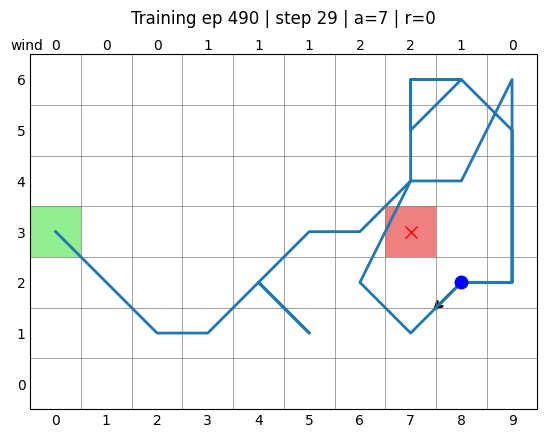

In [11]:
num_episodes = 500
wind_strengths = windy_gw.max(axis=0)

for e in range(num_episodes):
    episode = run_episode_train(epsilon=0.1)

    # Optional visualization (e.g., every 10 episodes)
    if e % 10 == 0:
        visualize_windy_episode(
            episode=episode,
            wind_strengths=wind_strengths,
            rows=7, cols=10,
            start=tuple(start_location),
            goal=tuple(goal),
            action_deltas=actions,
            sleep=0.03,
            title_prefix=f"Training ep {e}"
        )


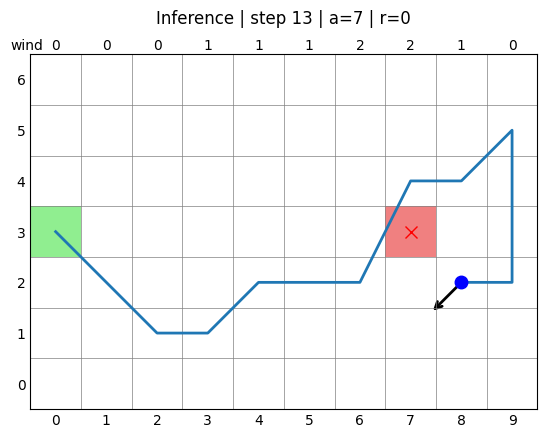

In [18]:
ep_infer = run_episode_infer()

visualize_windy_episode(
    episode=ep_infer,
    wind_strengths=windy_gw.max(axis=0),
    rows=7, cols=10,
    start=tuple(start_location),
    goal=tuple(goal),
    action_deltas=actions,
    sleep=0.08,
    title_prefix="Inference"
)
